In [1]:
import torch
from diffusers.utils import load_image
from PIL import Image
from insightface.app import FaceAnalysis
from insightface.utils import face_align



app = FaceAnalysis(name="buffalo_l", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0', 'cudnn_conv1d_pad_to_nc1d': '0', 'has_user_compute_stream': '0', 'gpu_external_alloc': '0', 'enable_cuda_graph': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'cudnn_conv_use_max_workspace': '1', 'tunable_op_enable': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0'}, 'CPUExecutionProvider': {}}
find model: C:\Users\doron/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0', 'cudnn_conv1d_pad_to_nc1d': '0', 'has_user

In [2]:
#!pip install git+https://github.com/tencent-ailab/IP-Adapter.git

In [3]:
import cv2
import dlib
import numpy as np
from PIL import Image, ImageOps

MODEL_PATH = "shape_predictor_5_face_landmarks.dat" # You need to download this file from http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
detector = dlib.get_frontal_face_detector() # Initialize dlib's face detector model

def get_face_landmarks(image_path):
    # Load the image
    image = cv2.imread(image_path)
    try:
        image = ImageOps.exif_transpose(image)
    except:
        print("exif problem, not rotating")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Initialize dlib's facial landmarks predictor
    predictor = dlib.shape_predictor("shape_predictor_5_face_landmarks.dat")  

    # Detect faces in the image
    faces = detector(gray)

    if len(faces) > 0:
        # Assume the first face is the target, you can modify this based on your requirements
        shape = predictor(gray, faces[0])
        landmarks = np.array([[p.x, p.y] for p in shape.parts()])
        return landmarks
    else:
        return None

def calculate_roll_and_yaw(landmarks):
    # Calculate the roll angle using the angle between the eyes
    roll_angle = np.degrees(np.arctan2(landmarks[1, 1] - landmarks[0, 1], landmarks[1, 0] - landmarks[0, 0]))

    # Calculate the yaw angle using the angle between the eyes and the tip of the nose
    yaw_angle = np.degrees(np.arctan2(landmarks[1, 1] - landmarks[2, 1], landmarks[1, 0] - landmarks[2, 0]))

    return roll_angle, yaw_angle

def detect_and_crop_head(input_image_path, factor=3.0):
    # Get facial landmarks
    landmarks = get_face_landmarks(input_image_path)

    if landmarks is not None:
        # Calculate the center of the face using the mean of the landmarks
        center_x = int(np.mean(landmarks[:, 0]))
        center_y = int(np.mean(landmarks[:, 1]))

        # Calculate the size of the cropped region
        size = int(max(np.max(landmarks[:, 0]) - np.min(landmarks[:, 0]),
                       np.max(landmarks[:, 1]) - np.min(landmarks[:, 1])) * factor)

        # Calculate the new coordinates for a 1:1 aspect ratio
        x_new = max(0, center_x - size // 2)
        y_new = max(0, center_y - size // 2)

        # Calculate roll and yaw angles
        roll_angle, yaw_angle = calculate_roll_and_yaw(landmarks)

        # Adjust the center coordinates based on the yaw and roll angles
        shift_x = int(size * 0.4 * np.sin(np.radians(yaw_angle)))
        shift_y = int(size * 0.2 * np.sin(np.radians(roll_angle)))

        #print(f'Roll angle: {roll_angle:.2f}, Yaw angle: {yaw_angle:.2f} shift_x: {shift_x}, shift_y: {shift_y}')

        center_x += shift_x
        center_y += shift_y

        # Calculate the new coordinates for a 1:1 aspect ratio
        x_new = max(0, center_x - size // 2)
        y_new = max(0, center_y - size // 2)

        # Read the input image using PIL
        image = Image.open(input_image_path)

        # Crop the head region with a 1:1 aspect ratio
        cropped_head = np.array(image.crop((x_new, y_new, x_new + size, y_new + size)))

        # Convert the cropped head back to PIL format
        cropped_head_pil = Image.fromarray(cropped_head)

        # Return the cropped head image
        return cropped_head_pil
    else:
        return None

In [4]:
from diffusers.utils import load_image
from PIL import Image

#image_file = "./assets/images/darth-vader.jpg"
#image_file = "./assets/images/vermeer-crop.jpg"
#image_file = "./assets/images/vermeer.jpg"

#image_file1 = "./assets/images/gal-gadot.jpg"
#image_file2 = "./assets/images/Margot-robbie-barbiecore-outfits-lede.jpg"

image_file1 = "./images/gal-gadot.jpg"
image_file2 = "./images/margot-robbie.jpg"


#image = load_image(image_file)
#image.resize((256, 256))

In [5]:
import cv2
image1 = cv2.imread(image_file1)
image2 = cv2.imread(image_file2)

faces1 = app.get(image1)
print(len(faces1))
faceid_embeds1 = torch.from_numpy(faces1[0].normed_embedding).unsqueeze(0)
faces2 = app.get(image2)
print(len(faces2))
faceid_embeds2 = torch.from_numpy(faces2[0].normed_embedding).unsqueeze(0)

# interpolate between the two faces
faceid_embeds = torch.lerp(faceid_embeds1, faceid_embeds2, 0.5)

#image1 = face_align.norm_crop(image1, landmark=faces1[0].kps, image_size=224)
#image2 = face_align.norm_crop(image2, landmark=faces2[0].kps, image_size=224)

img1 = detect_and_crop_head(image_file1, factor=2.5)
img2 = detect_and_crop_head(image_file2, factor=2.5)

image1 = cv2.cvtColor(np.array(img1.resize((224,224))), cv2.COLOR_RGB2BGR)
image2 = cv2.cvtColor(np.array(img2.resize((224,224))), cv2.COLOR_RGB2BGR)


c:\Users\doron\anaconda3\envs\sdxl\lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


1
1
exif problem, not rotating
exif problem, not rotating


In [6]:
#faceid_embeds = torch.from_numpy(faces[0].normed_embedding).unsqueeze(0)

#faceid_embeds.shape

In [7]:
from diffusers import StableDiffusionPipeline, DDIMScheduler, AutoencoderKL
from huggingface_hub import hf_hub_download
from PIL import Image

#from ip_adapter.ip_adapter_faceid import IPAdapterFaceID
from ip_adapter.ip_adapter_faceid import IPAdapterFaceIDPlus

base_model_path = "SG161222/Realistic_Vision_V5.1_noVAE"
#base_model_path = "dreamlike-art/dreamlike-anime-1.0"
vae_model_path = "stabilityai/sd-vae-ft-mse"
ip_ckpt = hf_hub_download(repo_id="h94/IP-Adapter-FaceID", filename="ip-adapter-faceid-plusv2_sd15.bin", repo_type="model")
image_encoder_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
device = "cuda"

bin c:\Users\doron\anaconda3\envs\sdxl\lib\site-packages\bitsandbytes\libbitsandbytes_cuda118.dll


A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [8]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


In [9]:

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)




Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
lora_weights = hf_hub_download(repo_id="h94/IP-Adapter-FaceID", filename="ip-adapter-faceid-plusv2_sd15_lora.safetensors", repo_type="model")
pipe.load_lora_weights(lora_weights)
#pipe.fuse_lora()   ##Causes a corruption in the ip_model

# load ip-adapter
ip_model = IPAdapterFaceIDPlus(pipe, image_encoder_path, ip_ckpt, device)



c:\Users\doron\anaconda3\envs\sdxl\lib\site-packages\diffusers\models\attention_processor.py:313: FutureWarning: `set_processor to offload LoRA` is deprecated and will be removed in version 0.26.0. In detail, removing LoRA layers via calling `set_processor` or `set_default_attn_processor` is deprecated. Please make sure to call `pipe.unload_lora_weights()` instead.
  deprecate(


In [11]:
# generate image
#prompt = "photo of a woman in pink dress in a garden"
prompt = "full body photo of a standing woman wearing a fuchsia dress in a bar"
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality, blurry, extra limbs, nude, naked, nsfw"


In [12]:
import numpy as np
t = 0.5

image = (image1 * (1 - t) + image2 * t).astype(np.uint8)
#image


(224, 224, 3)


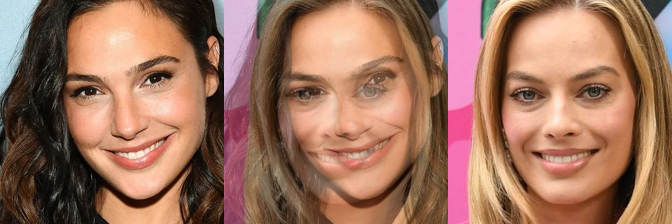

In [13]:
print(image.shape)
img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pil_images = [Image.fromarray(img1), Image.fromarray(img), Image.fromarray(img2)]
grid = image_grid(pil_images, 1, 3)
grid

  0%|          | 0/30 [00:00<?, ?it/s]

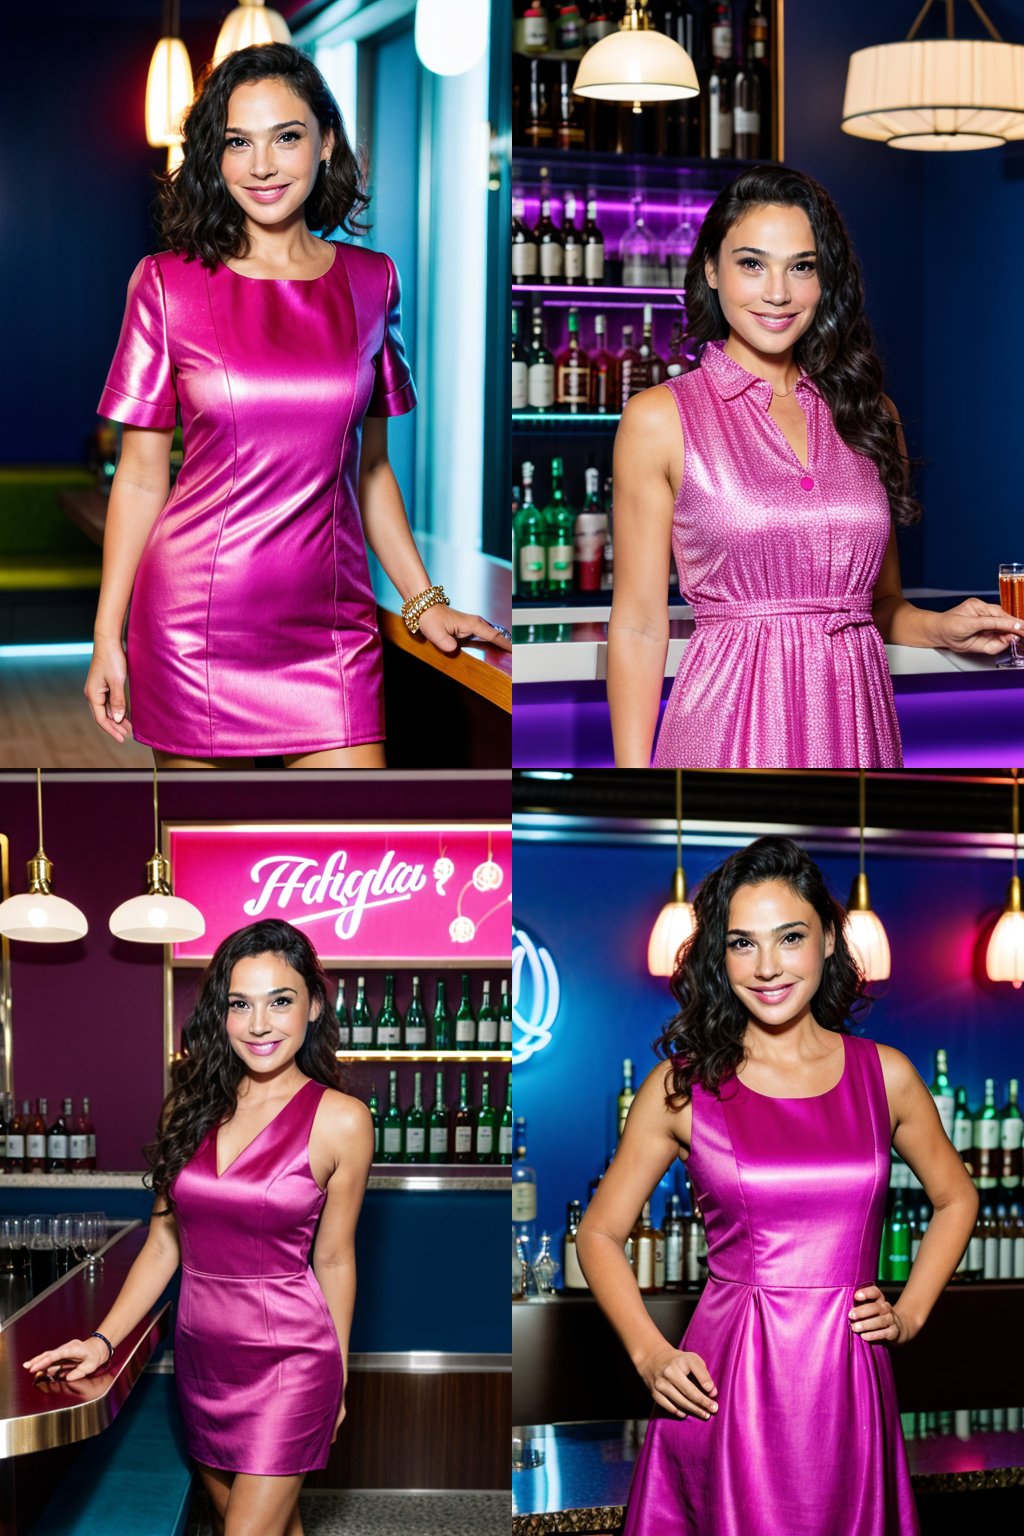

In [14]:
v2=True

images = ip_model.generate(
    prompt=prompt, negative_prompt=negative_prompt, face_image=image1, faceid_embeds=faceid_embeds1, shortcut=v2,  scale=0.9, s_scale=2.5, num_samples=4, width=512, height=768, num_inference_steps=30, seed=2023
)

grid = image_grid(images, 2, 2)
grid

  0%|          | 0/30 [00:00<?, ?it/s]

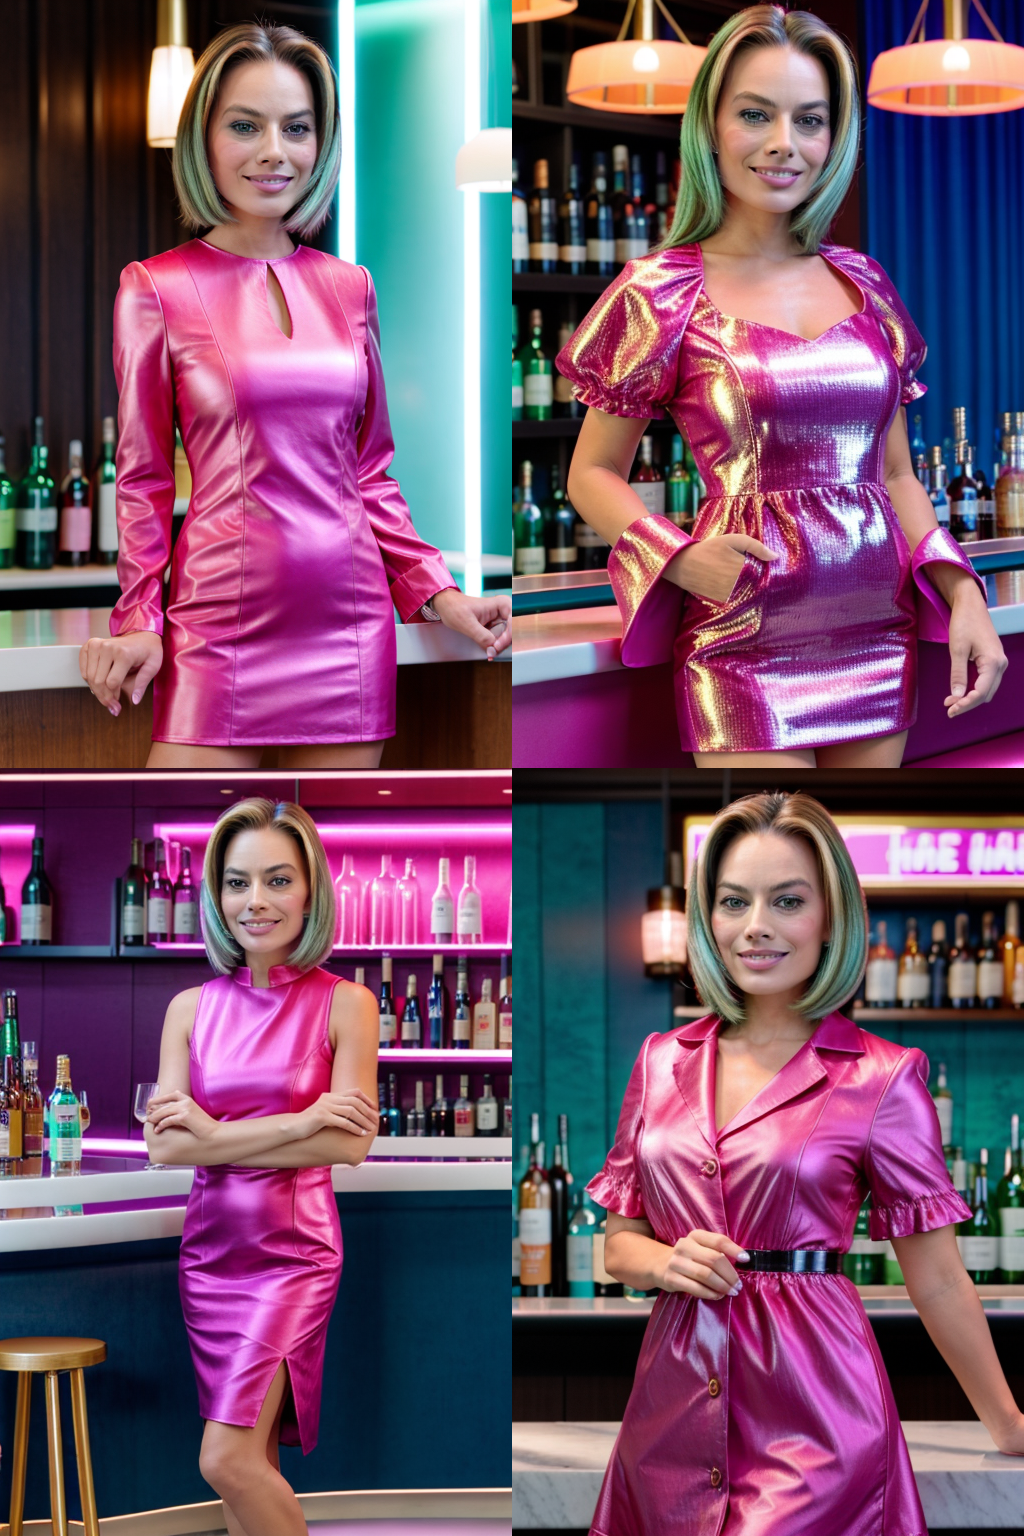

In [15]:
v2=True

images = ip_model.generate(
    prompt=prompt, negative_prompt=negative_prompt, face_image=image2, faceid_embeds=faceid_embeds2, shortcut=v2, scale=0.9, s_scale=2.5, num_samples=4, width=512, height=768, num_inference_steps=30, seed=2023
)

grid = image_grid(images, 2, 2)
grid

  0%|          | 0/30 [00:00<?, ?it/s]

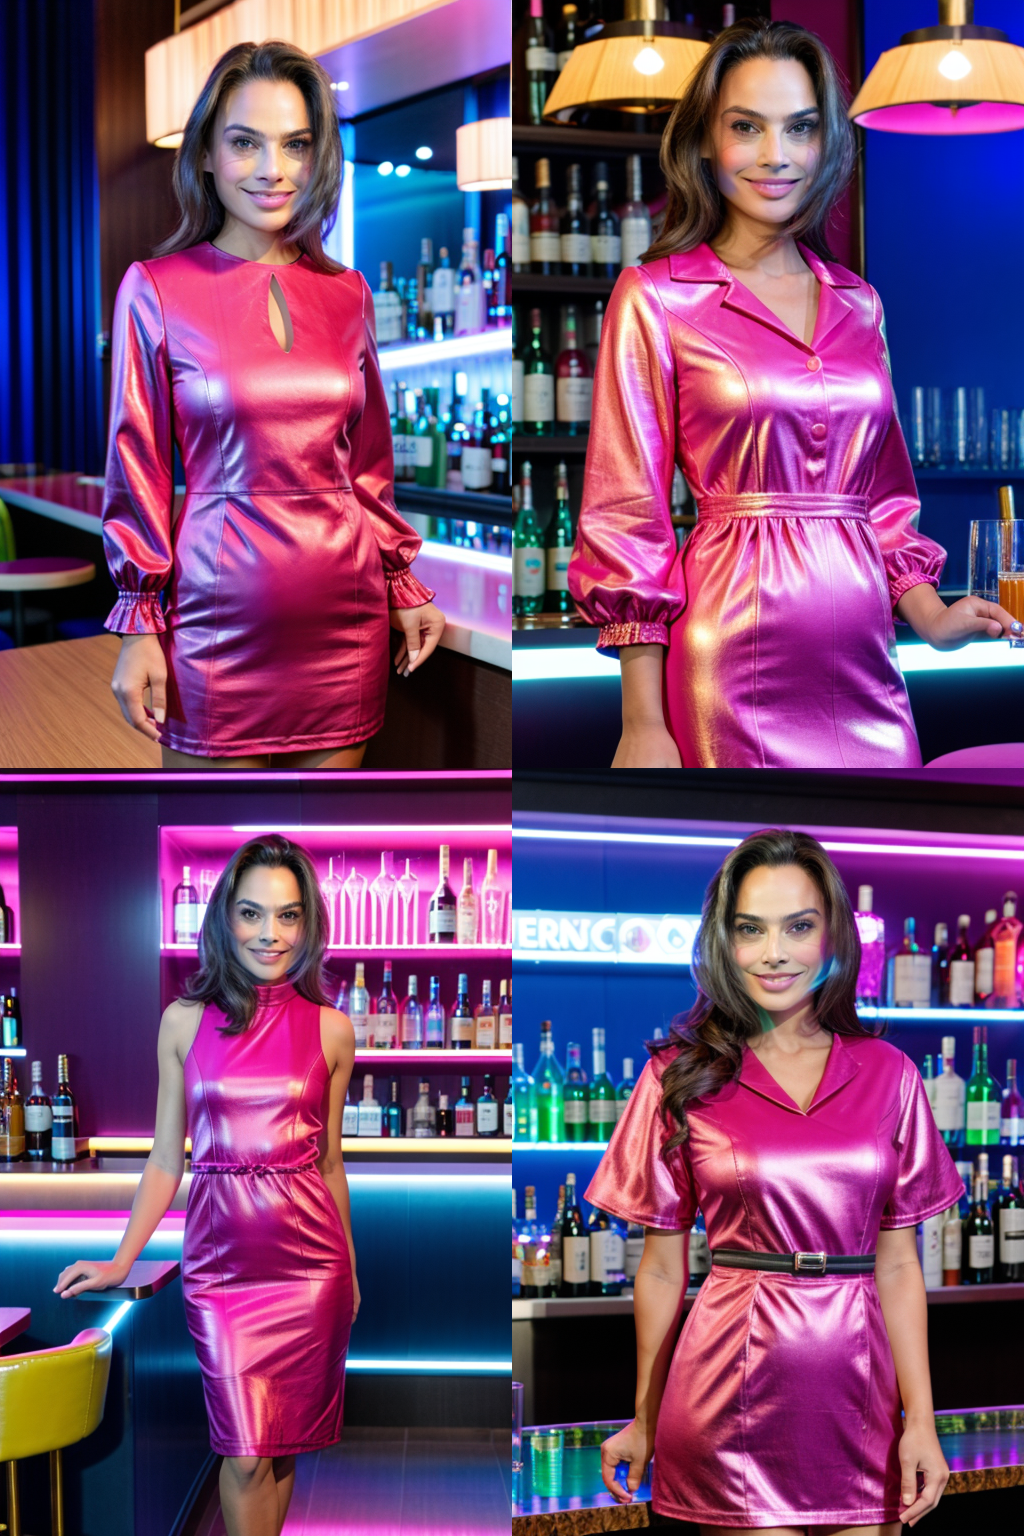

In [16]:
v2=True

images = ip_model.generate(
    prompt=prompt, negative_prompt=negative_prompt, face_image=image, faceid_embeds=faceid_embeds, shortcut=v2, scale=0.9, s_scale=2.5, num_samples=4, width=512, height=768, num_inference_steps=30, seed=2023
)

grid = image_grid(images, 2, 2)
grid

In [17]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import os
from IPython.display import clear_output

seed = 2023
scale=0.9
width = 512
height = 768
steps=30
num_of_results=5
v2=True
output_file_prefix="gal-margot--lerp-v2-scale2-shortcutTrue-customCrop" + prompt.replace(" ", "_")
os.makedirs(output_file_prefix, exist_ok=True)

#automatically prepare a list t of values between 0 and 1
t_space = torch.linspace(0, 1, num_of_results)
print(t_space[0])

idx = 0
for t in tqdm(t_space):
    print(f"t = {t}")
    mix_factor = t.item()
    image = (image1 * (1 - mix_factor) + image2 * mix_factor).astype(np.uint8)
    # interpolate between the two faces
    faceid_embeds = torch.lerp(faceid_embeds1, faceid_embeds2, t)
    images = ip_model.generate(prompt=prompt, negative_prompt=negative_prompt, face_image=image, faceid_embeds=faceid_embeds, shortcut=v2, s_scale=2.5, num_samples=4, scale=scale, width=width, height=height, num_inference_steps=30, seed=seed)
    grid = image_grid(images, 2, 2)
    grid.save(f"{output_file_prefix}/output-{seed}_{steps}_{int(scale * 100)}--{str(idx).zfill(4)}.jpg")
    idx += 1
    clear_output(wait=True)

100%|██████████| 5/5 [00:51<00:00, 10.23s/it]
